# Why does a topological layering emerge in neural networks?
_An example with XOR_

### Question

I found that the scope of action I identified in the mid-term were too unrealistic to begin with. Building the PRT-Complete Gnets and pruning to induce modern architectures was too complex. In order to make progress, I have adapted by narrowing down the scope.

Instead of using a PRT-Complete Gnet and inducing the formation of architectures, I am now investigating a much simpler question:

> Why is the organisation of multi-layer perceptrons into layers helpful for learning?

This represents my original research question narrowed down to the scope of MLPs, and the emergence of architectures down to the emergence of hierarchical, layered structures. The biological implications are still intact: neurons are allowed to form arbitrary connections, not just forward connections (as in traditional MLPs). It is interesting, then, that the brain organise itself into layers, with a direction of information transfer: such as the flow of visual data from V1, via V2, to V3.

Here is another way to frame the same question without starting from an observed phenomenon:

> If we start with a complete network (i.e. every neuron is connected to everything else), how can we induce a layered structure to emerge?

In other words, we are working out the correct inductive biases for a network to organise itself into layers. I have identified two directions through which this question can be investigated: inductive biases in weight initialisation, and inductive biases in training (e.g. pruning and/or modifications to learning algorithm).

### New Approach

The complete network:
- every hidden neurons (non-input neurons) is connected to each other
- for a problem with $k$ outputs, the first $k$ hidden neurons give the output
- to simulate a network with $h$ hidden layers, we evolve the complete network for $h+1$ timesteps

Inspired by the papers I read, I came up with different initialisation strategies:
- upper triangular (enforce topological orderliness)
- prune at the start with a winning lottery

And the following different training strategies:
- weight decay (decay weight, with the hope of eventually reducing some useless weights to near zero)
- norm-loss pruning (penalise too high a norm)
- threshold-based pruning (prune all edges with less than a certain weight)
- set-cover pruning ()

The control standard MLP has the theoretical minimum number of neurons needed to solve XOR (5 neurons). The control complete network has the same number of neurons, but no special initialisation, training, or pruning process. On top of the control complete network, we then inject different inductive biases.

Results are evaluated on several different metrics (all averaged across runs, with mean and standard deviation reported):
- speed of convergence (as measured on the Adam optimiser)
- final network sparsity
- final topological orderliness (weaker requirement)
- final hierarchical orderliness (stronger requirement)

I have started with testing the system on one of the simplest tasks in deep learning: XOR. This is to provide an intuition for the research, and to scout out which methods may work better before moving onto MNIST. I have hoped to be able to apply my findings to MNIST by this point, but unfortunately I have only just finished testing the various 

## Libraries & Setup

In [1]:
import sys
sys.path.append('../')

In [ ]:
from tqdm import tqdm
from math import sin, pi
from funcs import topk_mask

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchvision import data

In [2]:
device = 'cpu'

## Generate XOR Data

In [3]:
x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32).to(device)
y = torch.unsqueeze(torch.logical_xor(x[:, 0], x[:, 1]), 1).to(torch.float32).to(device)

## Simple Baseline

In [4]:
baseline = nn.Sequential(
    nn.Linear(2, 2, bias=True),
    nn.Sigmoid(),
    nn.Linear(2, 1, bias=True),
    nn.Sigmoid()
).to(device)

In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(baseline.parameters(), lr=0.01)

In [6]:
for epoch in range(10001):
    total_loss = 0
    for i, t in zip(x, y):
        optimizer.zero_grad()
        y_pred = baseline(i)
        loss = criterion(y_pred, t)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    ep_loss = total_loss / x.size(0)
    if epoch % 1000 == 0:
        print(f'epoch: {epoch}, loss: {ep_loss}')
    if ep_loss < 0.1e-3:
        print(f'epoch: {epoch}, loss: {ep_loss}')
        break

/home/yiding/micromamba/envs/nsarc/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch: 0, loss: 0.2595669887959957
epoch: 1000, loss: 0.041707193944603205
epoch: 2000, loss: 0.0010101023508468643
epoch: 3000, loss: 0.00010429365192976547
epoch: 3020, loss: 9.995582604460651e-05


In [7]:
for name, param in baseline.named_parameters():
    print(name, param)
baseline_params = list(baseline.parameters())

0.weight Parameter containing:
tensor([[-12.1485, -11.9684],
        [ -5.0915,  -5.0906]], requires_grad=True)
0.bias Parameter containing:
tensor([4.9772, 6.9697], requires_grad=True)
2.weight Parameter containing:
tensor([[-11.5690,  10.8592]], requires_grad=True)
2.bias Parameter containing:
tensor([-4.5509], requires_grad=True)


In [8]:
baseline(x)

tensor([[0.0055],
        [0.9923],
        [0.9923],
        [0.0158]], grad_fn=<SigmoidBackward0>)

## Complete Network

In [106]:
class CompleteLayer(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        k=0.5,
        activation=F.sigmoid,
        bias=False
    ):
        super(CompleteLayer, self).__init__()
        self.k = k
        self.bias = bias
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.units = input_size + hidden_size + output_size
        self.values = nn.Parameter(torch.zeros(hidden_size+output_size), requires_grad=False)
        self.weights = nn.Parameter(torch.randn(hidden_size+output_size, self.units), requires_grad=False)
        self.scores = nn.Parameter(torch.rand_like(self.weights))
        if bias:
            self.bias_weights = nn.Parameter(torch.rand_like(self.values))
        self.activation = activation
        
    def forward(
        self,
        inp,
        its=2,
        values=None,
        weights=None,
        scores=None,
        bias_weights=None
    ):
        if values is None: values = self.values
        if weights is None: weights = self.weights
        if scores is None: scores = self.scores
        if self.bias and bias_weights is None: bias_weights = self.bias_weights

        mask = topk_mask(self.scores, self.k)
        w = weights * mask

        for _ in range(its):
            x = torch.cat((values, inp), 0)
            if self.bias:
                values = self.activation(w @ x + bias_weights)
            else:
                values = self.activation(w @ x)
        
        return values[:self.output_size]
    
    def norm(self):
        norm = torch.linalg.matrix_norm(self.weights) # + torch.linalg.vector_norm(self.values)
        if self.bias:
            norm += torch.linalg.vector_norm(self.bias)
        return norm

In [107]:
complete = CompleteLayer(2, 20, 1, bias=False).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(complete.parameters(), lr=0.01)

In [108]:
beta = 0.5
n_epochs = 100001

for epoch in range(n_epochs):
    total_loss = 0
    for i, t in zip(x, y):
        optimizer.zero_grad()
        y_pred = complete(i)
        loss = criterion(y_pred, t)
        # loss += complete.norm() * beta
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    ep_loss = total_loss / x.size(0)
    if epoch % 1000 == 0:
        print(f'epoch: {epoch}, loss: {ep_loss}')
    if ep_loss < 3e-3:
        print(complete.norm())
        print(ep_loss)
        break

epoch: 0, loss: 0.42707584853633307
epoch: 1000, loss: 0.34618971310555935
epoch: 2000, loss: 0.31584566831588745
epoch: 3000, loss: 0.34618971310555935
epoch: 4000, loss: 0.39899104833602905
epoch: 5000, loss: 0.4009206295013428
epoch: 6000, loss: 0.4483805522322655


KeyboardInterrupt: 

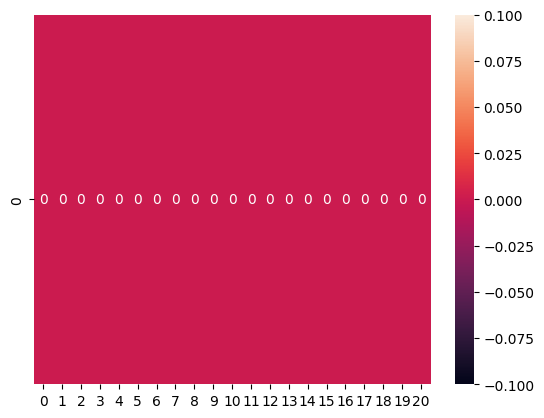

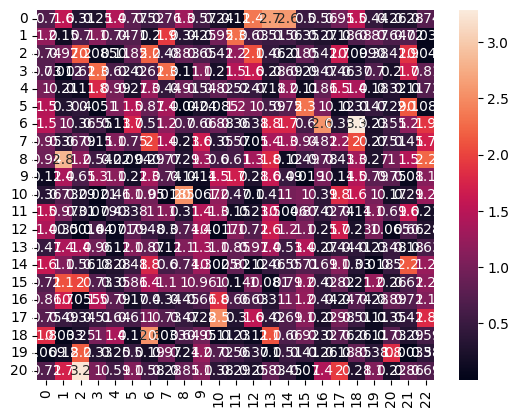

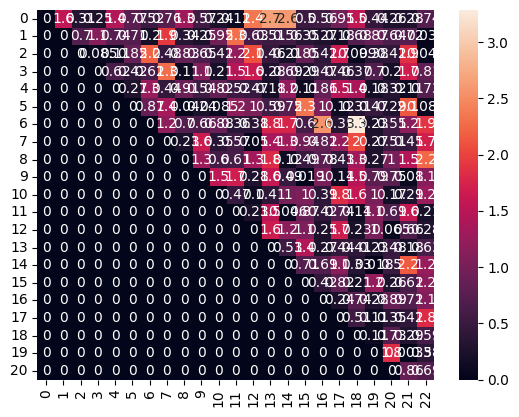

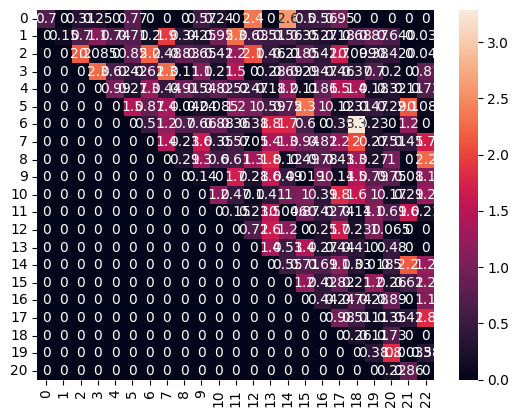

In [105]:
sns.heatmap(torch.abs(complete.values).to('cpu').detach().unsqueeze(0).numpy(), annot=True)
plt.show()
sns.heatmap(torch.abs(complete.weights).to('cpu').detach().numpy(), annot=True)
plt.show()
sns.heatmap(torch.abs(complete.weights.triu(1)).to('cpu').detach().numpy(), annot=True)
plt.show()
sns.heatmap(torch.abs(complete.weights * topk_mask(complete.scores, complete.k)).to('cpu').detach().numpy(), annot=True)
plt.show()

In [98]:
complete(torch.tensor([0, 1], dtype=torch.float32).to(device),
         weights=complete.weights.triu(1))

tensor([0.8086], grad_fn=<SliceBackward0>)

In [95]:
state = torch.cat((torch.tensor([0, 1], dtype=torch.float32).to(device),
                   complete.values.to(device))).to(device)

In [48]:
for name, param in complete.named_parameters():
    print(name, param)
complete_params = list(complete.parameters())

values Parameter containing:
tensor([-0.5482, -0.7350, -1.1240], requires_grad=True)
weights Parameter containing:
tensor([[ 3.8438,  5.4372, -7.4613, -3.0803, -0.4651],
        [-0.2742,  0.5175,  1.7298,  4.5674, -6.9908],
        [-1.8291, -0.8075, -1.4124, -7.3926, -8.0539]], requires_grad=True)


## Discussion

### Different Pruning Strategies

### Different Initialisation Strategies

## Towards the final

### Issues & Plans
- Learning rate tuning

### Further Steps